In [1]:
import numpy as np
import time
import pygame

import gymnasium as gym
from gymnasium import spaces
from gymnasium.error import DependencyNotInstalled
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import matplotlib.pyplot as plt

pygame 2.1.2 (SDL 2.0.16, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Define the map
MAP = [
    "+---------+",
    "|R: | : :G|",
    "| :C| : : |",
    "| : : : : |",
    "| | : | :M|",
    "|Y| : |B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)
FRAME_RATE = 10  # Frames per second

class MultiAgentTaxiEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": FRAME_RATE,
    }

    def __init__(self, render_mode=None, num_agents=2, num_tasks=3):
        super(MultiAgentTaxiEnv, self).__init__()
        self.desc = np.asarray(MAP, dtype="c")
        self.num_agents = num_agents
        self.num_tasks = num_tasks

        # Define the possible locations and their colors
        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (3, 4), (1, 5)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255)]

        # Define some predefined sequences
        self.predefined_sequences = [
            [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (3, 4)], # Sequence 1
            [(0, 4), (4, 0), (4, 3), (1, 2), (3, 4), (0, 0)], # Sequence 2
            [(4, 0), (4, 3), (1, 2), (3, 4), (0, 0), (0, 4)], # Sequence 3
            [(4, 3), (1, 2), (3, 4), (0, 0), (0, 4), (4, 0)], # Sequence 4
        ]

        # Define no-spawn areas (colored blocks and walls)
        self.no_spawn_areas = set(self.locs)

        # Action space: 6 actions for each agent (move in 4 directions, pick up, drop off)
        self.action_space = spaces.MultiDiscrete([6] * self.num_agents)
        # Observation space: Positions and statuses of agents and tasks
        self.observation_space = spaces.Box(
            low=-1, high=5, shape=(self.num_agents * 3 + self.num_tasks * 4 + self.num_agents,), dtype=np.int32
        )

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

        self.step_penalty = -1
        self.pickup_reward = 20
        self.dropoff_reward = 50
        self.wrong_action_penalty = -5
        self.collaborative_reward = 10
        self.task_distribution_penalty = -5 # Penalty for unbalanced task distribution

        self.grid_size = (len(MAP) - 2, len(MAP[0]) - 2)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        np.random.seed(seed)

        while True:  # Loop until a valid configuration is found
            # Initialize agents' positions and task states
            self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)  # x, y, occupancy status
            
            # Exclude no-spawn areas for taxi spawning
            possible_taxi_spawns = [(x, y) for x in range(5) for y in range(5) if (x, y) not in self.no_spawn_areas]

            if len(possible_taxi_spawns) < self.num_agents:
                raise ValueError("Not enough available locations to place all taxis.")
            
            self.agents[:, :2] = np.array([possible_taxi_spawns.pop(np.random.randint(0, len(possible_taxi_spawns))) for _ in range(self.num_agents)])

            self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)

            # Choose a predefined sequence
            chosen_sequence = self.predefined_sequences[np.random.randint(len(self.predefined_sequences))]
            pickup_locs = chosen_sequence[:self.num_tasks]
            dropoff_locs = chosen_sequence[self.num_tasks:self.num_tasks*2]

            for i in range(self.num_tasks):
                self.tasks[i] = np.array([pickup_locs[i][0], pickup_locs[i][1], dropoff_locs[i][0], dropoff_locs[i][1]])

            # Validate that no taxis are on colored blocks and all tasks are spawned
            valid_configuration = True
            for agent in self.agents:
                if (agent[0], agent[1]) in self.no_spawn_areas:
                    valid_configuration = False
                    break
            
            if valid_configuration and len(self.tasks) == self.num_tasks:
                break

        return self._get_obs()

    # def reset(self, seed=None, options=None):
    #     super().reset(seed=seed)
    #     np.random.seed(seed)

    #     while True:  # Loop until a valid configuration is found
    #         # Initialize agents' positions and task states
    #         self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)  # x, y, occupancy status
    #         self.agent_has_task = [False] * self.num_agents  # Initialize task status for each agent
            
    #         # Exclude no-spawn areas for taxi spawning
    #         possible_taxi_spawns = [(x, y) for x in range(5) for y in range(5) if (x, y) not in self.no_spawn_areas]

    #         if len(possible_taxi_spawns) < self.num_agents:
    #             raise ValueError("Not enough available locations to place all taxis.")
            
    #         self.agents[:, :2] = np.array([possible_taxi_spawns.pop(np.random.randint(0, len(possible_taxi_spawns))) for _ in range(self.num_agents)])

    #         self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)

    #         # Choose a predefined sequence
    #         chosen_sequence = self.predefined_sequences[np.random.randint(len(self.predefined_sequences))]
    #         pickup_locs = chosen_sequence[:self.num_tasks]
    #         dropoff_locs = chosen_sequence[self.num_tasks:self.num_tasks*2]

    #         for i in range(self.num_tasks):
    #             self.tasks[i] = np.array([pickup_locs[i][0], pickup_locs[i][1], dropoff_locs[i][0], dropoff_locs[i][1]])

    #         # Validate that no taxis are on colored blocks and all tasks are spawned
    #         valid_configuration = True
    #         for agent in self.agents:
    #             if (agent[0], agent[1]) in self.no_spawn_areas:
    #                 valid_configuration = False
    #                 break
            
    #         if valid_configuration and len(self.tasks) == self.num_tasks:
    #             break
        
    #     return self._get_obs(), {}

    # def _get_obs(self):
    #     distances = []
    #     for agent in self.agents:
    #         if any(task[0] != -1 for task in self.tasks):
    #             distances.append(min([abs(agent[0] - task[0]) + abs(agent[1] - task[1]) for task in self.tasks if task[0] != -1]))
    #         else:
    #             distances.append(0)  # If no valid tasks, set distance to 0

    #     return np.concatenate([self.agents.flatten(), self.tasks.flatten(), np.array(distances)])
    def _get_obs(self):
        # Flatten the agents and tasks to ensure consistent shape
        agents_flat = self.agents.flatten()
        tasks_flat = self.tasks.flatten()
        distances = []
        for agent in self.agents:
            if any(task[0] != -1 for task in self.tasks):
                distances.append(min([abs(agent[0] - task[0]) + abs(agent[1] - task[1]) for task in self.tasks if task[0] != -1]))
            else:
                distances.append(0)  # If no valid tasks, set distance to 0

        obs = np.concatenate([agents_flat, tasks_flat, np.array(distances)])
        return obs

    def _move(self, position, action):
        """
        Move the agent to a new position based on the action.
        Actions: 0 - up, 1 - right, 2 - down, 3 - left
        """
        x, y = position
        next_pos = position  # Initialize to current position
        if action == 0 and x > 0:  # Up
            next_pos = (x - 1, y)
        elif action == 1 and y < self.grid_size[1] - 1:  # Right
            next_pos = (x, y + 1)
        elif action == 2 and x < self.grid_size[0] - 1:  # Down
            next_pos = (x + 1, y)
        elif action == 3 and y > 0:  # Left
            next_pos = (x, y - 1)
        return next_pos

    def _pickup(self, position, agent_index):
        """
        Attempt to pick up a task at the agent's position.
        """
        for task_index, task in enumerate(self.tasks):
            if tuple(task[:2]) == position and not self.agent_has_task[agent_index]:
                self.agent_has_task[agent_index] = True
                self.tasks[task_index] = (-1, -1, task[2], task[3])  # Mark task as picked up
                return True
        return False

    def _dropoff(self, position, agent_index):
        """
        Attempt to drop off a task at the agent's position.
        """
        if self.agent_has_task[agent_index]:
            for loc in self.locs:
                if position == loc:
                    self.agent_has_task[agent_index] = False
                    return True
        return False

    def _update_tasks(self):
        """
        Update the tasks' positions based on the agents' actions.
        """
        for i, task in enumerate(self.tasks):
            if task[0] == -1:
                continue
            for j, agent in enumerate(self.agents):
                if tuple(task[:2]) == tuple(agent[:2]):
                    self.tasks[i] = (task[0], task[1], -1, -1)
                    break

    def step(self, actions):
        assert self.action_space.contains(actions), f"Invalid action: {actions}"

        rewards = np.zeros(self.num_agents)
        terminated = False

        for i, action in enumerate(actions):
            agent_pos = tuple(self.agents[i][:2])
            next_pos = agent_pos  # Initialize to current position

            if action < 4:  # Move actions
                next_pos = self._move(agent_pos, action)
                if next_pos != agent_pos:
                    self.agents[i][:2] = next_pos
                rewards[i] += self.step_penalty
            elif action == 4:  # Pickup action
                if self._pickup(agent_pos, i):
                    rewards[i] += self.pickup_reward
                else:
                    rewards[i] += self.wrong_action_penalty
            elif action == 5:  # Dropoff action
                if self._dropoff(agent_pos, i):
                    rewards[i] += self.dropoff_reward
                else:
                    rewards[i] += self.wrong_action_penalty

            if not self.agent_has_task[i]:
                if self._pickup(next_pos, i):
                    rewards[i] += self.pickup_reward

            if self.agent_has_task[i]:
                if self._dropoff(next_pos, i):
                    rewards[i] += self.dropoff_reward

        if all(task[0] == -1 for task in self.tasks):
            terminated = True

        self._update_tasks()

        if self.render_mode == "human":
            self.render()

        return self._get_obs(), np.sum(rewards), terminated, False, {}

    def assign_tasks(self):
        agent_positions = [tuple(agent[:2]) for agent in self.agents]
        task_positions = [tuple(task[:2]) for task in self.tasks if task[0] != -1]
        
        task_assignments = [-1] * self.num_tasks
        
        for task_index, task_pos in enumerate(task_positions):
            min_distance = float('inf')
            assigned_agent = -1
            
            for agent_index, agent_pos in enumerate(agent_positions):
                distance = abs(agent_pos[0] - task_pos[0]) + abs(agent_pos[1] - task_pos[1])
                
                if distance < min_distance:
                    min_distance = distance
                    assigned_agent = agent_index
            
            task_assignments[task_index] = assigned_agent
        
        return task_assignments
    
    def _move_towards(self, start, end):
        """
        Move from the start position to the end position using a simple greedy approach.
        """
        if start == end:
            return start

        x, y = start
        target_x, target_y = end

        if x < target_x:
            return (x + 1, y)
        elif x > target_x:
            return (x - 1, y)
        elif y < target_y:
            return (x, y + 1)
        elif y > target_y:
            return (x, y - 1)

        return start
    
    def _find_closest_task(self, agent_pos):
        min_distance = float('inf')
        closest_task = None
        
        for task in self.tasks:
            if task[0] != -1:  # Task not picked up yet
                task_pos = (task[0], task[1])
                distance = abs(agent_pos[0] - task_pos[0]) + abs(agent_pos[1] - task_pos[1])
                
                if distance < min_distance:
                    min_distance = distance
                    closest_task = task_pos
        
        return closest_task

    def render(self, mode='human'):
        if self.render_mode is None:
            return

        try:
            import pygame  # dependency to pygame only if rendering with human
        except ImportError as e:
            raise DependencyNotInstalled(
                'pygame is not installed, run `pip install "gymnasium[toy-text]"`'
            ) from e

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Multi-Agent Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert self.window is not None, "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if self.taxi_imgs is None:
            file_names = [
                "img/cab_front.png",
                "img/cab_rear.png",
                "img/cab_right.png",
                "img/cab_left.png",
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = "img/passenger.png"
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = "img/hotel.png"
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                "img/gridworld_median_left.png",
                "img/gridworld_median_horiz.png",
                "img/gridworld_median_right.png",
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                "img/gridworld_median_top.png",
                "img/gridworld_median_vert.png",
                "img/gridworld_median_bottom.png",
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = "img/taxi_background.png"
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)
                elif desc[y][x] == b"M":
                    color_cell = pygame.Surface(self.cell_size)
                    color_cell.set_alpha(128)
                    color_cell.fill((255, 0, 255))
                    self.window.blit(color_cell, cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        for agent in self.agents:
            self.window.blit(self.taxi_imgs[0], self.get_surf_loc((agent[0], agent[1])))

        for task in self.tasks:
            if task[0] != -1:
                self.window.blit(self.passenger_img, self.get_surf_loc((task[0], task[1])))
                self.window.blit(self.destination_img, self.get_surf_loc((task[2], task[3])))

        if self.render_mode == "rgb_array":
            return pygame.surfarray.array3d(self.window)

        pygame.display.flip()

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (map_loc[0] + 1) * self.cell_size[1]

    def close(self):
        if self.window is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()

In [3]:
# for PPO
# Display the frame using matplotlib# Define the map
MAP = [
    "+---------+",
    "|R: | : :G|",
    "| :C| : : |",
    "| : : : : |",
    "| | : | :M|",
    "|Y| : |B: |",
    "+---------+",
]
WINDOW_SIZE = (550, 350)
FRAME_RATE = 10  # Frames per second

class MultiAgentTaxiEnv(gym.Env):
    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": FRAME_RATE,
    }

    def __init__(self, render_mode=None, num_agents=2, num_tasks=3):
        super(MultiAgentTaxiEnv, self).__init__()
        self.desc = np.asarray(MAP, dtype="c")
        self.num_agents = num_agents
        self.num_tasks = num_tasks

        # Define the possible locations and their colors
        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (3, 4), (1, 5)]
        self.locs_colors = [(255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255)]

        # Define some predefined sequences
        self.predefined_sequences = [
            [(0, 0), (0, 4), (4, 0), (4, 3), (1, 2), (3, 4)], # Sequence 1
            [(0, 4), (4, 0), (4, 3), (1, 2), (3, 4), (0, 0)], # Sequence 2
            [(4, 0), (4, 3), (1, 2), (3, 4), (0, 0), (0, 4)], # Sequence 3
            [(4, 3), (1, 2), (3, 4), (0, 0), (0, 4), (4, 0)], # Sequence 4
        ]

        # Define no-spawn areas (colored blocks and walls)
        self.no_spawn_areas = set(self.locs)

        # Action space: 6 actions for each agent (move in 4 directions, pick up, drop off)
        self.action_space = spaces.MultiDiscrete([6] * self.num_agents)
        # Observation space: Positions and statuses of agents and tasks
        self.observation_space = spaces.Box(
            low=-1, high=5, shape=(self.num_agents * 3 + self.num_tasks * 4 + self.num_agents,), dtype=np.int32
        )

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None

        self.step_penalty = -1
        self.pickup_reward = 20
        self.dropoff_reward = 50
        self.wrong_action_penalty = -5
        self.collaborative_reward = 10
        self.task_distribution_penalty = -5 # Penalty for unbalanced task distribution

        self.grid_size = (len(MAP) - 2, len(MAP[0]) - 2)

    # def reset(self, seed=None, options=None):
    #     super().reset(seed=seed)
    #     np.random.seed(seed)

    #     while True:  # Loop until a valid configuration is found
    #         # Initialize agents' positions and task states
    #         self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)  # x, y, occupancy status
    #         self.agent_has_task = [False] * self.num_agents  # Initialize task status for each agent
            
    #         # Exclude no-spawn areas for taxi spawning
    #         possible_taxi_spawns = [(x, y) for x in range(5) for y in range(5) if (x, y) not in self.no_spawn_areas]

    #         if len(possible_taxi_spawns) < self.num_agents:
    #             raise ValueError("Not enough available locations to place all taxis.")
            
    #         self.agents[:, :2] = np.array([possible_taxi_spawns.pop(np.random.randint(0, len(possible_taxi_spawns))) for _ in range(self.num_agents)])

    #         self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)

    #         # Choose a predefined sequence
    #         chosen_sequence = self.predefined_sequences[np.random.randint(len(self.predefined_sequences))]
    #         pickup_locs = chosen_sequence[:self.num_tasks]
    #         dropoff_locs = chosen_sequence[self.num_tasks:self.num_tasks*2]

    #         for i in range(self.num_tasks):
    #             self.tasks[i] = np.array([pickup_locs[i][0], pickup_locs[i][1], dropoff_locs[i][0], dropoff_locs[i][1]])

    #         # Validate that no taxis are on colored blocks and all tasks are spawned
    #         valid_configuration = True
    #         for agent in self.agents:
    #             if (agent[0], agent[1]) in self.no_spawn_areas:
    #                 valid_configuration = False
    #                 break
            
    #         if valid_configuration and len(self.tasks) == self.num_tasks:
    #             break
        
    #     return self._get_obs(), {}

    # def _get_obs(self):
    #     distances = []
    #     for agent in self.agents:
    #         if any(task[0] != -1 for task in self.tasks):
    #             distances.append(min([abs(agent[0] - task[0]) + abs(agent[1] - task[1]) for task in self.tasks if task[0] != -1]))
    #         else:
    #             distances.append(0)  # If no valid tasks, set distance to 0

    #     return np.concatenate([self.agents.flatten(), self.tasks.flatten(), np.array(distances)])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        np.random.seed(seed)

        while True:  # Loop until a valid configuration is found
            # Initialize agents' positions and task states
            self.agents = np.zeros((self.num_agents, 3), dtype=np.int32)  # x, y, occupancy status
            self.agent_has_task = [False] * self.num_agents  # Initialize task status for each agent

            # Exclude no-spawn areas for taxi spawning
            possible_taxi_spawns = [(x, y) for x in range(5) for y in range(5) if (x, y) not in self.no_spawn_areas]

            if len(possible_taxi_spawns) < self.num_agents:
                raise ValueError("Not enough available locations to place all taxis.")

            self.agents[:, :2] = np.array([possible_taxi_spawns.pop(np.random.randint(0, len(possible_taxi_spawns))) for _ in range(self.num_agents)])

            self.tasks = np.zeros((self.num_tasks, 4), dtype=np.int32)

            # Choose a predefined sequence
            chosen_sequence = self.predefined_sequences[np.random.randint(len(self.predefined_sequences))]
            pickup_locs = chosen_sequence[:self.num_tasks]
            dropoff_locs = chosen_sequence[self.num_tasks:self.num_tasks * 2]

            for i in range(self.num_tasks):
                self.tasks[i] = np.array([pickup_locs[i][0], pickup_locs[i][1], dropoff_locs[i][0], dropoff_locs[i][1]])

            # Validate that no taxis are on colored blocks and all tasks are spawned
            valid_configuration = True
            for agent in self.agents:
                if (agent[0], agent[1]) in self.no_spawn_areas:
                    valid_configuration = False
                    break

            if valid_configuration and len(self.tasks) == self.num_tasks:
                break

        return self._get_obs(), {}


    def _get_obs(self):
        # Flatten the agents and tasks to ensure consistent shape
        agents_flat = self.agents.flatten()
        tasks_flat = self.tasks.flatten()
        distances = []
        for agent in self.agents:
            if any(task[0] != -1 for task in self.tasks):
                distances.append(min([abs(agent[0] - task[0]) + abs(agent[1] - task[1]) for task in self.tasks if task[0] != -1]))
            else:
                distances.append(0)  # If no valid tasks, set distance to 0

        obs = np.concatenate([agents_flat, tasks_flat, np.array(distances)])
        return obs

    def _move(self, position, action):
        """
        Move the agent to a new position based on the action.
        Actions: 0 - up, 1 - right, 2 - down, 3 - left
        """
        x, y = position
        next_pos = position  # Initialize to current position
        if action == 0 and x > 0:  # Up
            next_pos = (x - 1, y)
        elif action == 1 and y < self.grid_size[1] - 1:  # Right
            next_pos = (x, y + 1)
        elif action == 2 and x < self.grid_size[0] - 1:  # Down
            next_pos = (x + 1, y)
        elif action == 3 and y > 0:  # Left
            next_pos = (x, y - 1)
        return next_pos

    def _pickup(self, position, agent_index):
        """
        Attempt to pick up a task at the agent's position.
        """
        for task_index, task in enumerate(self.tasks):
            if tuple(task[:2]) == position and not self.agent_has_task[agent_index]:
                self.agent_has_task[agent_index] = True
                self.tasks[task_index] = (-1, -1, task[2], task[3])  # Mark task as picked up
                return True
        return False

    def _dropoff(self, position, agent_index):
        """
        Attempt to drop off a task at the agent's position.
        """
        if self.agent_has_task[agent_index]:
            for loc in self.locs:
                if position == loc:
                    self.agent_has_task[agent_index] = False
                    return True
        return False

    def _update_tasks(self):
        """
        Update the tasks' positions based on the agents' actions.
        """
        for i, task in enumerate(self.tasks):
            if task[0] == -1:
                continue
            for j, agent in enumerate(self.agents):
                if tuple(task[:2]) == tuple(agent[:2]):
                    self.tasks[i] = (task[0], task[1], -1, -1)
                    break
    
    # def step(self, actions):
    #     assert self.action_space.contains(actions), f"Invalid action: {actions}"

    #     rewards = np.zeros(self.num_agents)
    #     terminated = False

    #     for i, action in enumerate(actions):
    #         agent_pos = tuple(self.agents[i][:2])
    #         next_pos = agent_pos  # Initialize to current position

    #         if action < 4:  # Move actions
    #             next_pos = self._move(agent_pos, action)
    #             if next_pos != agent_pos:
    #                 self.agents[i][:2] = next_pos
    #             rewards[i] += self.step_penalty
    #         elif action == 4:  # Pickup action
    #             if self._pickup(agent_pos, i):
    #                 rewards[i] += self.pickup_reward
    #             else:
    #                 rewards[i] += self.wrong_action_penalty
    #         elif action == 5:  # Dropoff action
    #             if self._dropoff(agent_pos, i):
    #                 rewards[i] += self.dropoff_reward
    #             else:
    #                 rewards[i] += self.wrong_action_penalty

    #         if not self.agent_has_task[i]:
    #             if self._pickup(next_pos, i):
    #                 rewards[i] += self.pickup_reward

    #         if self.agent_has_task[i]:
    #             if self._dropoff(next_pos, i):
    #                 rewards[i] += self.dropoff_reward

    #     if all(task[0] == -1 for task in self.tasks):
    #         terminated = True

    #     self._update_tasks()

    #     if self.render_mode == "human":
    #         self.render()

    #     return self._get_obs(), np.sum(rewards), terminated, False, {}

    def step(self, actions):
        assert self.action_space.contains(actions), f"Invalid action: {actions}"

        rewards = np.zeros(self.num_agents)
        terminated = False

        for i, action in enumerate(actions):
            agent_pos = tuple(self.agents[i][:2])
            next_pos = agent_pos  # Initialize to current position

            if action < 4:  # Move actions
                next_pos = self._move(agent_pos, action)
                if next_pos != agent_pos:
                    self.agents[i][:2] = next_pos
                rewards[i] += self.step_penalty
            elif action == 4:  # Pickup action
                if self._pickup(agent_pos, i):
                    rewards[i] += self.pickup_reward
                else:
                    rewards[i] += self.wrong_action_penalty
            elif action == 5:  # Dropoff action
                if self._dropoff(agent_pos, i):
                    rewards[i] += self.dropoff_reward
                else:
                    rewards[i] += self.wrong_action_penalty

            if not self.agent_has_task[i]:
                if self._pickup(next_pos, i):
                    rewards[i] += self.pickup_reward

            if self.agent_has_task[i]:
                if self._dropoff(next_pos, i):
                    rewards[i] += self.dropoff_reward

        if all(task[0] == -1 for task in self.tasks):
            terminated = True

        self._update_tasks()

        if self.render_mode == "human":
            self.render()

        return self._get_obs(), np.sum(rewards), terminated, False, {}

    def render(self, mode='human'):
        if self.render_mode is None:
            return

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Multi-Agent Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert self.window is not None, "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if self.taxi_imgs is None:
            file_names = [
                "img/cab_front.png",
                "img/cab_rear.png",
                "img/cab_right.png",
                "img/cab_left.png",
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.passenger_img is None:
            file_name = "img/passenger.png"
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = "img/hotel.png"
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            file_names = [
                "img/gridworld_median_left.png",
                "img/gridworld_median_horiz.png",
                "img/gridworld_median_right.png",
            ]
            self.median_horiz = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.median_vert is None:
            file_names = [
                "img/gridworld_median_top.png",
                "img/gridworld_median_vert.png",
                "img/gridworld_median_bottom.png",
            ]
            self.median_vert = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.background_img is None:
            file_name = "img/taxi_background.png"
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)
                elif desc[y][x] == b"M":
                    color_cell = pygame.Surface(self.cell_size)
                    color_cell.set_alpha(128)
                    color_cell.fill((255, 0, 255))
                    self.window.blit(color_cell, cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))

        for agent in self.agents:
            self.window.blit(self.taxi_imgs[0], self.get_surf_loc((agent[0], agent[1])))

        for task in self.tasks:
            if task[0] != -1:
                self.window.blit(self.passenger_img, self.get_surf_loc((task[0], task[1])))
                self.window.blit(self.destination_img, self.get_surf_loc((task[2], task[3])))

        if self.render_mode == "rgb_array":
            return pygame.surfarray.array3d(self.window)

        pygame.display.flip()

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (map_loc[0] + 1) * self.cell_size[1]

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [4]:
# Discretize the observation space
def discretize_state(state):
    return tuple(np.round(state, decimals=0).astype(int))

def policyIteration(env, discountRate, maxNumberOfIterations, convergenceTolerance):
    # Initialize policy and value function dictionaries
    initialPolicy = {}
    valueFunctionDict = {}

    # Initialize policy and value function for each possible discretized state
    for _ in range(maxNumberOfIterations):
        obs, _ = env.reset()
        state = discretize_state(obs.flatten())
        if state not in initialPolicy:
            initialPolicy[state] = np.ones(env.action_space.nvec[0]) / env.action_space.nvec[0]
            valueFunctionDict[state] = 0

    for iteration in range(maxNumberOfIterations):
        print(f"Iteration - {iteration} - of policy iteration algorithm")

        valueFunctionDict = evaluatePolicy(env, valueFunctionDict, initialPolicy, discountRate, maxNumberOfIterations, convergenceTolerance)
        improvedPolicy, policyStable = improvePolicy(env, valueFunctionDict, env.action_space.nvec[0], discountRate)

        # Print value function
        print(f"Value Function at iteration {iteration}:")
        for state, value in valueFunctionDict.items():
            print(f"State: {state}, Value: {value}")

        if all(np.allclose(initialPolicy[state], improvedPolicy[state]) for state in initialPolicy):
            break
        initialPolicy = improvedPolicy
    
    return initialPolicy, valueFunctionDict

def evaluatePolicy(env, valueFunctionDict, policy, discountRate, maxNumberOfIterations, convergenceTolerance):
    for iteration in range(maxNumberOfIterations):
        delta = 0
        for state in policy:
            v = valueFunctionDict[state]
            valueFunctionDict[state] = sum(
                policy[state][a] * (reward + discountRate * valueFunctionDict.get(next_state, 0))
                for a in range(env.action_space.nvec[0])
                for next_state, reward in [step(env, state, a)]
            )
            delta = max(delta, abs(v - valueFunctionDict[state]))
        print(f"Delta after policy evaluation iteration {iteration}: {delta}")
        if delta < convergenceTolerance:
            break
    return valueFunctionDict

def step(env, state, action):
    # Simulate environment step with a given state and action
    env.reset()
    env.agents = np.array(state[:env.num_agents*3]).reshape((env.num_agents, 3))
    env.tasks = np.array(state[env.num_agents*3:env.num_agents*3 + env.num_tasks*4]).reshape((env.num_tasks, 4))
    env.agent_has_task = list(state[env.num_agents*3 + env.num_tasks*4:])

    obs, reward, terminated, truncated, _ = env.step([action] * env.num_agents)
    next_state = discretize_state(obs.flatten())

    return next_state, reward

def improvePolicy(env, valueFunctionDict, numberActions, discountRate):
    policyStable = True
    newPolicy = {}

    for state in valueFunctionDict:
        oldAction = np.argmax(env.action_space.nvec[0] * [valueFunctionDict[state]])
        actionValues = np.zeros(numberActions)

        for action in range(numberActions):
            for next_state, reward in [step(env, state, action)]:
                actionValues[action] += reward + discountRate * valueFunctionDict.get(next_state, 0)

        bestAction = np.argmax(actionValues)
        newPolicy[state] = np.eye(numberActions)[bestAction]

        if bestAction != oldAction:
            policyStable = False

    return newPolicy, policyStable

In [15]:
# Initialize the environment
env = MultiAgentTaxiEnv(render_mode='human', num_agents=2, num_tasks=3)

# Policy Iteration parameters
discountRate = 0.9
maxNumberOfIterations = 1000
convergenceTolerance = 1e-3

# Run Policy Iteration
optimal_policy, optimal_value_function = policyIteration(env, discountRate, maxNumberOfIterations, convergenceTolerance)

# Display the optimal policy and value function
print("Optimal Policy:")
print(optimal_policy)
print("Optimal Value Function:")
print(optimal_value_function)

Iteration - 0 - of policy iteration algorithm
Delta after policy evaluation iteration 0: 31.716666666666665
Delta after policy evaluation iteration 1: 10.615000000000002
Delta after policy evaluation iteration 2: 5.220619687500001
Delta after policy evaluation iteration 3: 2.7922702500000014
Delta after policy evaluation iteration 4: 1.4601587769316406
Delta after policy evaluation iteration 5: 0.8661134327599953
Delta after policy evaluation iteration 6: 0.5067929497756722
Delta after policy evaluation iteration 7: 0.2942863216223035
Delta after policy evaluation iteration 8: 0.17106266508919177
Delta after policy evaluation iteration 9: 0.11168385058318009
Delta after policy evaluation iteration 10: 0.07304221174161896
Delta after policy evaluation iteration 11: 0.04783803686954968
Delta after policy evaluation iteration 12: 0.031364921368222554
Delta after policy evaluation iteration 13: 0.020580711883871672
Delta after policy evaluation iteration 14: 0.013512087620918933
Delta afte

In [ ]:
# test the policy
obs, _ = env.reset()
state = discretize_state(obs.flatten())
done = False

while not done:
    action = np.argmax(optimal_policy[state])
    obs, reward, done, _ = env.step([action] * env.num_agents)
    state = discretize_state(obs.flatten())
    env.render()
    time.sleep(1)

env.close()

In [13]:
# Ensure your environment is compatible
check_env(env, warn=True)

# Create and train the PPO model
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)

# Save the model
model.save("ppo_multiagent_taxi")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 127      |
|    ep_rew_mean     | -366     |
| time/              |          |
|    fps             | 158      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 113         |
|    ep_rew_mean          | -302        |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009219766 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss  

In [19]:
env = MultiAgentTaxiEnv(render_mode='human', num_agents=2, num_tasks=3)

# Load the model
model = PPO.load("ppo_multiagent_taxi")

total_rewards = []

# Test the model
obs, _ = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, truncated, info = env.step(action)
    total_rewards.append(rewards)  # Collect rewards
    env.render()
    time.sleep(0.5)
    if done or truncated:
        obs, _ = env.reset()

: 

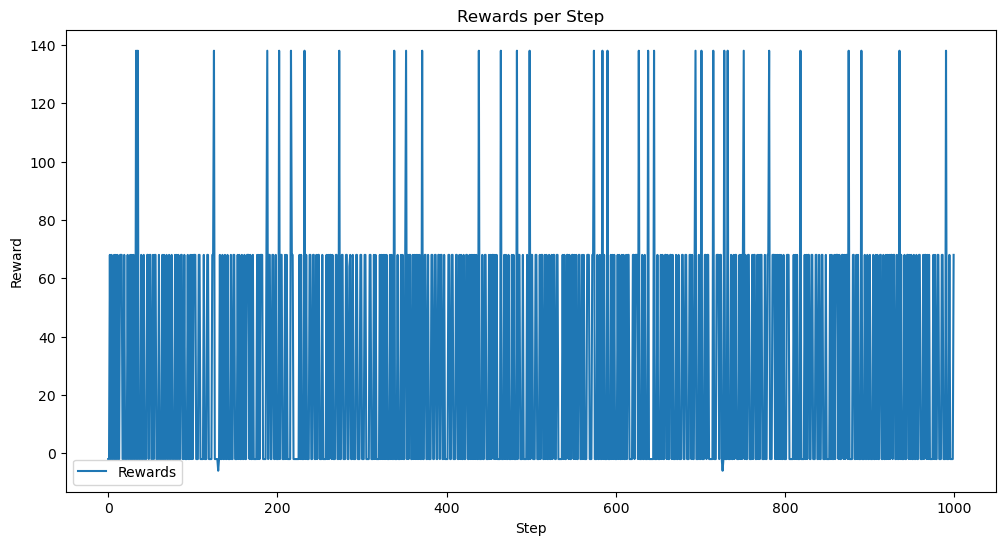

In [14]:
# Plot the rewards
plt.figure(figsize=(12, 6))
plt.plot(total_rewards, label='Rewards')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Rewards per Step')
plt.legend()
plt.show()